In [34]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pysal as ps
import mplleaflet

In [35]:
data = gpd.read_file("data_combined_new.shp")

In [48]:
data = data.dropna()

In [50]:
data.columns

Index([u'BoroCT2010', u'BoroCT20_1',   u'BoroCode',   u'BoroName',
       u'BoroName_1', u'CDEligibil',     u'CT2010',    u'CTLabel',
           u'Field1',    u'NTACode',    u'NTAName',   u'OBJECTID',
             u'PUMA', u'Shape_Ar_1', u'Shape_Area', u'Shape_Leng',
                u'X',   u'fipstemp', u'flag_age_1', u'flag_agevu',
       u'flag_com_1', u'flag_commu',   u'flag_emp', u'flag_emp_7',
       u'flag_noi_1', u'flag_noins', u'flag_pop_1', u'flag_popde',
         u'flag_pov', u'flag_pov_7',   u'flag_sum', u'flag_sum_7',
             u'fpop',   u'geometry',      u'hhold', u'hhold_inco',
             u'mpop',       u'name',      u'noins', u'pct_age_vu',
          u'pct_emp', u'pct_f_vuln', u'pct_m_vuln',  u'pct_noins',
          u'pct_pov',   u'pct_qbuf',  u'poly_area', u'popdensity',
              u'pov',       u'prop', u'rank_agevu', u'rank_commu',
         u'rank_emp', u'rank_incom', u'rank_noins', u'rank_popde',
         u'rank_pov',   u'rank_sum',   u'totalpop', u'transpor

In [58]:
data.to_file('data_shape.shp', driver='ESRI Shapefile')

In [59]:
psGeom = ps.open('data_shape.shp', 'r')

In [60]:
len(set(data['BoroCT2010']))

2064

In [61]:
len(data1)

2064

In [62]:
type(data['BoroCT2010'][1])

unicode

In [63]:
W = ps.buildContiguity(psGeom, criterion='queen', ids=data['BoroCT2010'].values.tolist())
    
    

Island ids:  [u'3103400', u'4107201', u'2051600', u'2000100']


In [64]:
W['1015400']

{u'1014402': 1.0,
 u'1014602': 1.0,
 u'1014802': 1.0,
 u'1015200': 1.0,
 u'1015601': 1.0,
 u'1015801': 1.0}

In [65]:
W.transform = 'R'

In [66]:
W['1015400']

{u'1014402': 0.16666666666666666,
 u'1014602': 0.16666666666666666,
 u'1014802': 0.16666666666666666,
 u'1015200': 0.16666666666666666,
 u'1015601': 0.16666666666666666,
 u'1015801': 0.16666666666666666}

In [67]:
Y = data['rank_sum'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

In [68]:
sl = ps.lag_spatial(W, Y)
data['Spatial_w_percent'] = sl

In [69]:
mi = ps.Moran(Y, W)
mi.I
mi.p_sim

0.001

In [70]:
mi.I

0.66298497606209761

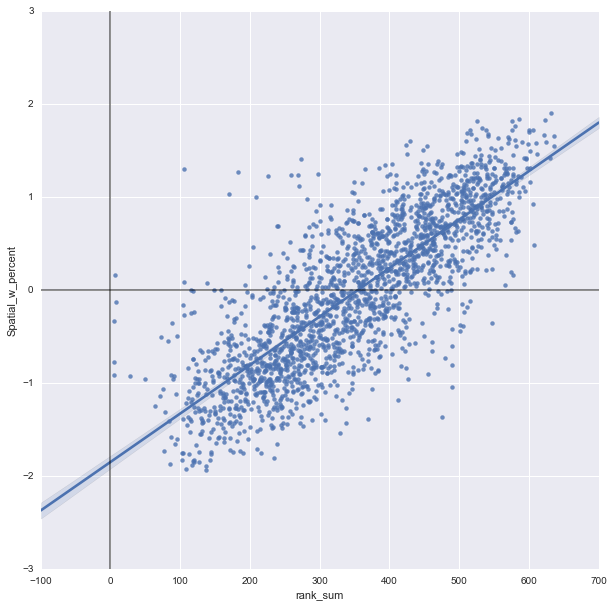

In [71]:
# It's time to look at the Moran Scatter Plot to inspet the results

f, ax = plt.subplots(1, figsize=(10,10))
sns.regplot(x='rank_sum', y='Spatial_w_percent', data=data)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

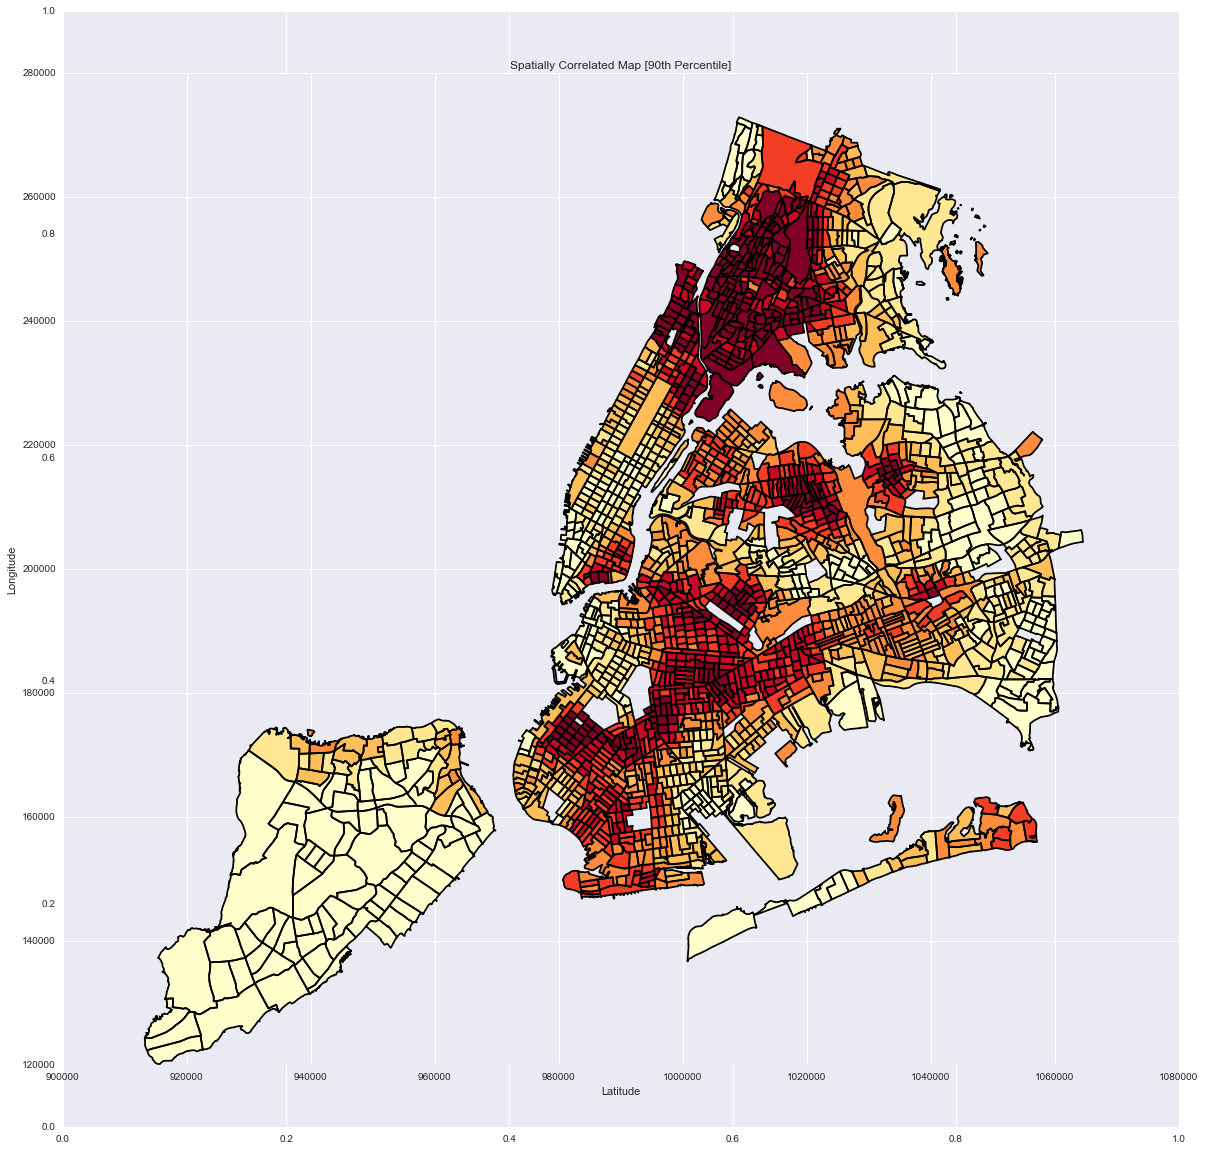

In [72]:
#### THE BELOW CODE SHOULD WORK FOR MOST INSTALLATION
f, ax = plt.subplots(1, figsize=(20,20))
data.plot(column='Spatial_w_percent', scheme='QUANTILES',k=7, alpha=1, colormap='YlOrRd')#,label='data')

plt.title("Spatially Correlated Map [90th Percentile]")
plt.xlabel('Latitude')
plt.ylabel("Longitude")
#mplleaflet.display(fig=f, crs=data.crs)
#plt.legend()
#### BUT IF NOT, PLEASE USE THE BELOW INSTEAD (and comment the previous blob)
# data.plot(column='w_percent', scheme='QUANTILES', k=7, alpha=1.0, colormap='YlOrRd', figsize=(10,10))
# mplleaflet.display(crs=data.crs)

In [73]:
data.columns

Index([       u'BoroCT2010',        u'BoroCT20_1',          u'BoroCode',
                u'BoroName',        u'BoroName_1',        u'CDEligibil',
                  u'CT2010',           u'CTLabel',            u'Field1',
                 u'NTACode',           u'NTAName',          u'OBJECTID',
                    u'PUMA',        u'Shape_Ar_1',        u'Shape_Area',
              u'Shape_Leng',                 u'X',          u'fipstemp',
              u'flag_age_1',        u'flag_agevu',        u'flag_com_1',
              u'flag_commu',          u'flag_emp',        u'flag_emp_7',
              u'flag_noi_1',        u'flag_noins',        u'flag_pop_1',
              u'flag_popde',          u'flag_pov',        u'flag_pov_7',
                u'flag_sum',        u'flag_sum_7',              u'fpop',
                u'geometry',             u'hhold',        u'hhold_inco',
                    u'mpop',              u'name',             u'noins',
              u'pct_age_vu',           u'pct_emp', 

In [74]:
spatial_file = data[['Spatial_w_percent','BoroCT2010']]

In [75]:
spatial_file.to_csv('NewData_SpatialCorrelation.csv')

In [ ]:
data.plot(column='w_percent', scheme='QUANTILES', k=7, alpha=1.0, colormap='YlOrRd')
mplleaflet.display(crs=data.crs)

In [ ]:
data[['BoroCT2010','w_percent']]
set(data['w_percent'])

In [ ]:
lisa = ps.Moran_Local(Y, W)

In [ ]:
S = lisa.p_sim < 0.05

In [ ]:
Q = lisa.q

In [ ]:
# Next, we'll turn those into a GeoDataFrame for visualization.

records = map(lambda x: (data.iloc[x]['BoroCT2010'], Q[x], data.geometry.iloc[x]),
              [i for i,s in enumerate(S) if s])


gdata = gpd.GeoDataFrame(records, columns=('BoroCT2010', 'quadrant', 'geometry'))
gdata.head()

In [ ]:
f, ax = plt.subplots(1, figsize=(10,10))
gdata.plot(column='quadrant', scheme='QUANTILES', k=4, alpha=1.0, colormap='Blues')